# MMM + CLV Example Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
# import pymc.sampling_jax
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns

from pymmmc.transformers import geometric_adstock_vectorized, logistic_saturation
from pymmmc.utils import generate_fourier_modes

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [8, 4]
plt.rcParams["figure.dpi"] = 100

## Data Generation Process

**Note: We will hide this**

In [2]:
seed = list(map(ord, ("MMM+CLV=<3")))
rng = np.random.default_rng(seed)

### Generate Customer Aquisition Data

See [Media Effect Estimation with Orbit's KTR Model](https://juanitorduz.github.io/orbit_mmm/).

#### Date Range

In [3]:
# date range
min_date = pd.to_datetime("2018-04-01")
max_date = pd.to_datetime("2022-10-01")

data_df = pd.DataFrame(
    data={"date_week": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
).assign(
    year=lambda x: x["date_week"].dt.year,
    month=lambda x: x["date_week"].dt.month,
    dayofyear=lambda x: x["date_week"].dt.dayofyear,
)

n = data_df.shape[0]
n

235

#### Media Costs Data

- Raw Signal

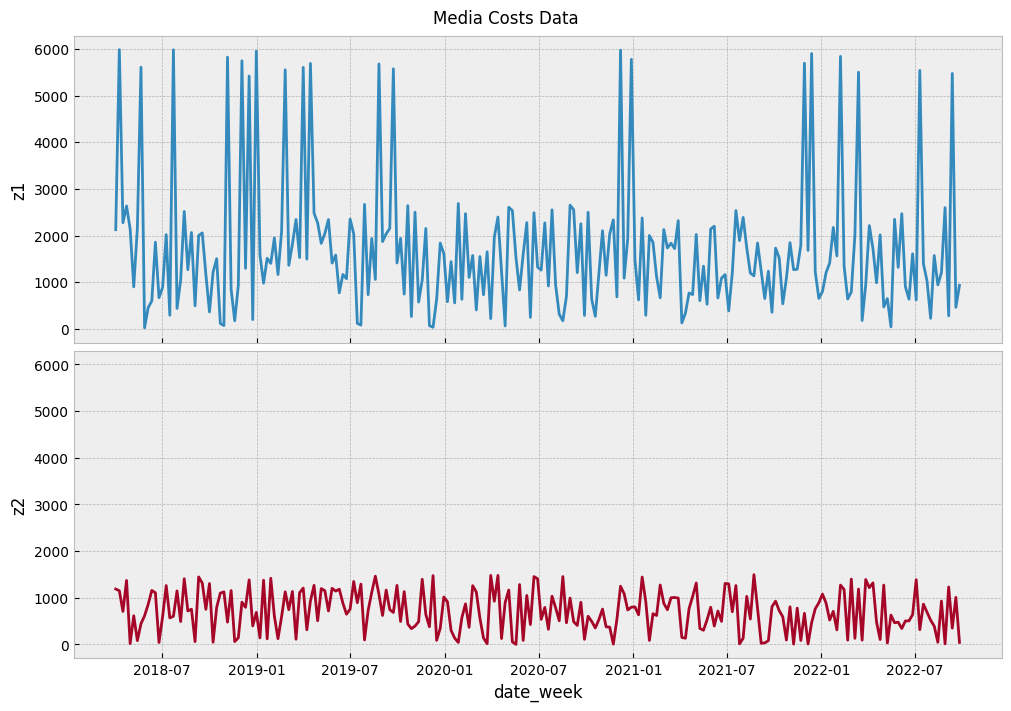

In [4]:
# media data
z1 = rng.uniform(low=0.0, high=1.0, size=n)
data_df["z1"] = 6_000 * np.where(z1 > 0.9, z1, z1 / 2)

z2 = rng.uniform(low=0.0, high=1.0, size=n)
data_df["z2"] = 1_500 * np.where(z2 > 0.2, z2, z2 / 2)

fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 7), sharex=True, sharey=True, layout="constrained"
)
sns.lineplot(x="date_week", y="z1", data=data_df, color="C0", ax=ax[0])
sns.lineplot(x="date_week", y="z2", data=data_df, color="C1", ax=ax[1])
fig.suptitle("Media Costs Data");

- Effect Signal

In [5]:
# scale features
data_df["z1_scaled"] = MinMaxScaler().fit_transform(X=data_df[["z1"]])

data_df["z2_scaled"] = MinMaxScaler().fit_transform(X=data_df[["z2"]])

# apply saturation transformation
lam1 = 5
lam2 = 3

data_df["z1_saturated"] = logistic_saturation(
    x=data_df["z1_scaled"], lam=lam1
).eval()

data_df["z2_saturated"] = logistic_saturation(
    x=data_df["z2_scaled"], lam=lam2
).eval()

# apply geometric adstock transformation
alpha1 = 0.7
alpha2 = 0.3

data_df["z1_saturated_adstock"] = (
    geometric_adstock_vectorized(
        x=data_df[["z1_saturated"]], alpha=alpha1, l_max=12, normalize=False
    )
    .eval()
    .flatten()
)

data_df["z2_saturated_adstock"] = (
    geometric_adstock_vectorized(
        x=data_df[["z2_saturated"]], alpha=alpha2, l_max=12, normalize=False
    )
    .eval()
    .flatten()
)

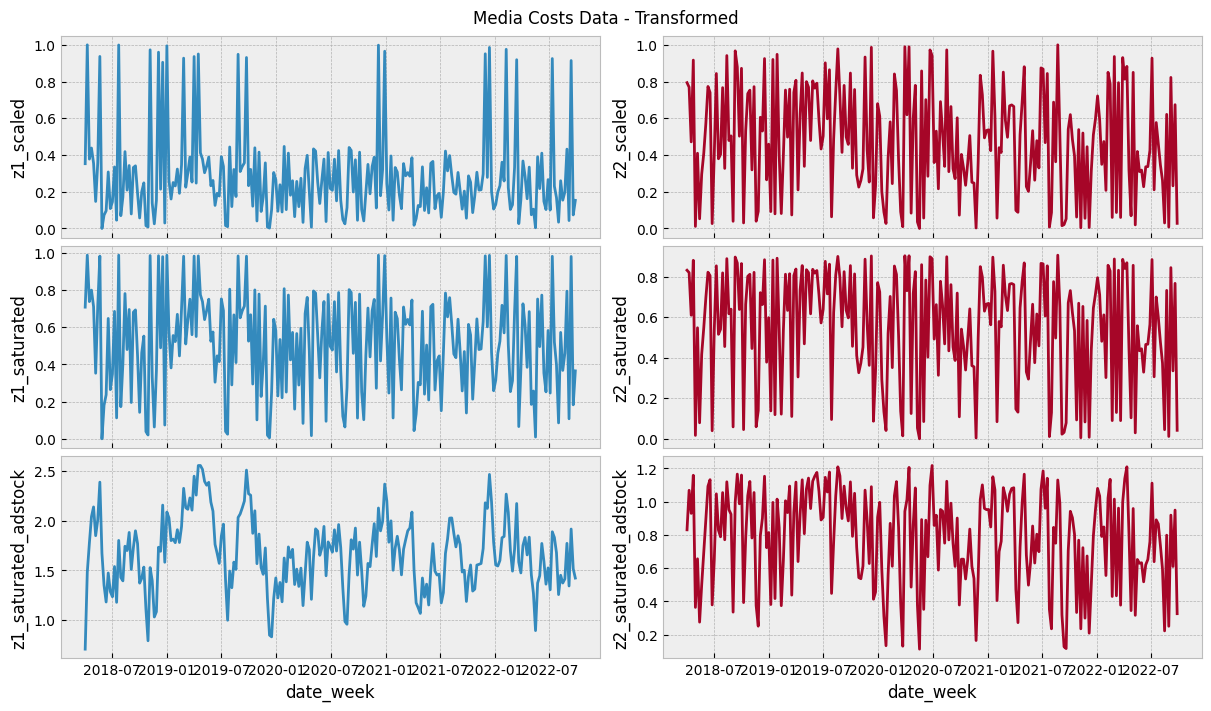

In [6]:
fig, ax = plt.subplots(
    nrows=3, ncols=2, figsize=(12, 7), sharex=True, sharey=False, layout="constrained"
)
sns.lineplot(x="date_week", y="z1_scaled", data=data_df, color="C0", ax=ax[0, 0])
sns.lineplot(x="date_week", y="z2_scaled", data=data_df, color="C1", ax=ax[0, 1])
sns.lineplot(x="date_week", y="z1_saturated", data=data_df, color="C0", ax=ax[1, 0])
sns.lineplot(x="date_week", y="z2_saturated", data=data_df, color="C1", ax=ax[1, 1])
sns.lineplot(x="date_week", y="z1_saturated_adstock", data=data_df, color="C0", ax=ax[2, 0])
sns.lineplot(x="date_week", y="z2_saturated_adstock", data=data_df, color="C1", ax=ax[2, 1])
fig.suptitle("Media Costs Data - Transformed");

#### Trend \& Seasonal Components

In [7]:
# data_df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10) ** (1 / 4) - 1

# data_df["cs"] = - np.sin(2 * 2 * np.pi * data_df["dayofyear"] / 365.5) 
# data_df["cc"] = np.cos(1 * 2 * np.pi * data_df["dayofyear"] / 365.5)
# data_df["seasonality"] = 0.5 * (data_df["cs"] + data_df["cc"])

# fig, ax = plt.subplots()
# sns.lineplot(x="date_week", y="trend", color="C4", label="trend", data=data_df, ax=ax)
# sns.lineplot(x="date_week", y="seasonality", color="C6", label="seasonality", data=data_df, ax=ax)
# ax.legend(loc="upper left")
# ax.set(title="Trend & Seasonality Components", ylabel=None);

#### Target Variable

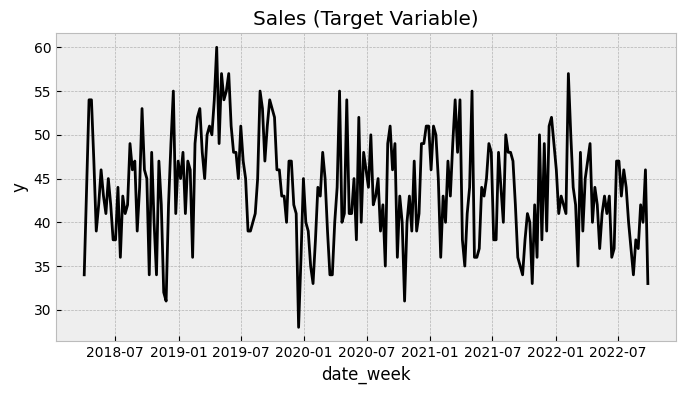

In [8]:
data_df["intercept"] = 2.0
data_df["epsilon"] = rng.normal(loc=0.0, scale=0.3, size=n)

data_df["y"] = (10 * (
    data_df["intercept"]
    + data_df["z1_saturated_adstock"]
    + data_df["z2_saturated_adstock"]
    + data_df["epsilon"]
)).astype(int)

fig, ax = plt.subplots()
sns.lineplot(x="date_week", y="y", color="black", data=data_df, ax=ax)
ax.set(title="Sales (Target Variable)");

### Ad-hoc user source attribution

In [9]:
df = data_df.copy()
df.drop(columns=['year', 'month', 'dayofyear', 'z1', 'z2', 'z1_scaled', 'z2_scaled', 'z1_saturated', 'z2_saturated', 'epsilon'], inplace=True)
df.rename(columns={"z1_saturated_adstock": "z1", "z2_saturated_adstock": "z2", "intercept": "z0"}, inplace=True)
total_effects = df["z1"] + df["z2"] + df["z0"]
df["y_z1"] = (df["z1"] / total_effects * df["y"]).astype(int)
df["y_z2"] = (df["z2"] / total_effects * df["y"]).astype(int)
df["y_z0"] = (df["z0"] / total_effects * df["y"]).astype(int)
df["y"] = df["y_z1"] + df["y_z2"] + df["y_z0"]  # Ignore rounding issues
df

,date_week,z1,z2,z0,y,y_z1,y_z2,y_z0
0,2018-04-02,0.707422,0.830889,2.0,32,6,7,19
1,2018-04-09,1.481810,1.068370,2.0,43,14,10,19
2,2018-04-16,1.774457,0.929626,2.0,52,20,10,22
3,2018-04-23,2.040870,1.158782,2.0,53,21,12,20
4,2018-04-30,2.138859,0.364540,2.0,45,22,3,20
...,...,...,...,...,...,...,...,...
230,2022-08-29,1.772162,0.251158,2.0,36,16,2,18
231,2022-09-05,1.343241,0.919044,2.0,41,13,9,19
232,2022-09-12,1.916322,0.610629,2.0,38,16,5,17
233,2022-09-19,1.515912,0.949373,2.0,44,15,9,20


In [10]:
# TODO: Is this approximately correct? 
# Is the channel saturation constant over time? 
# If not, the CAC estimated below shoud be biased towards lower values

z1_avg_cacq = (data_df['z1'] / (df['y_z1'] + 1)).mean()
z2_avg_cacq = (data_df['z2'] / (df['y_z2'] + 1)).mean()
               
print(f"Avg Cacq Z1: {z1_avg_cacq:.2f}")
print(f"Avg Cacq Z2: {z2_avg_cacq:.2f}")

Avg Cacq Z1: 95.38
Avg Cacq Z2: 77.20


### Generate transaction data

In [362]:
# Beta Geo parameters
# Z1 does more transactions on average
z0_bg_r = 25
z1_bg_r = 20 / 10
z2_bg_r = 30 * 10

z0_bg_alpha = 4
z1_bg_alpha = 4 / 10
z2_bg_alpha = 4 * 10

z0_bg_a = 80
z1_bg_a = 60 / 10
z2_bg_a = 100 * 10

z0_bg_b = 1000
z1_bg_b = 1000 / 10
z2_bg_b = 1000 * 10


# Gamma-Gamma parameters
# Z1 does slightly less valuable transactions
z0_gg_p = 0.7
z1_gg_p = 0.8
z2_gg_p = 0.6

z0_gg_q = 4.0
z1_gg_q = 4.0
z2_gg_q = 4.0 / 10

z0_gg_v = 15.0
z1_gg_v = 15.0
z2_gg_v = 15.0 / 10

In [363]:
user_id = []
user_source = []

user_bg_lam = []
user_bg_p = []
user_bg_T0 = []

user_gg_p = []
user_gg_nu = []


j = 0
for i, row in df.iterrows():        
    user_id.extend(np.arange(row["y"]) + j)    
    j += row["y"]
    user_source.extend(["z0"] * row["y_z0"] + ["z1"] * row["y_z1"] + ["z2"] * row["y_z2"])
    
    user_bg_lam.extend(rng.gamma(z0_bg_r, 1/z0_bg_alpha, size=row["y_z0"]))
    user_bg_lam.extend(rng.gamma(z1_bg_r, 1/z1_bg_alpha, size=row["y_z1"]))
    user_bg_lam.extend(rng.gamma(z2_bg_r, 1/z2_bg_alpha, size=row["y_z2"]))    
    user_bg_p.extend(rng.beta(z0_bg_a, z0_bg_b, size=row["y_z0"]))
    user_bg_p.extend(rng.beta(z1_bg_a, z1_bg_b, size=row["y_z1"]))
    user_bg_p.extend(rng.beta(z2_bg_a, z2_bg_b, size=row["y_z2"]))            
    user_bg_T0.extend([i]*row["y"])
        
    user_gg_p.extend([z0_gg_p] * row["y_z0"])
    user_gg_p.extend([z1_gg_p] * row["y_z1"])
    user_gg_p.extend([z2_gg_p] * row["y_z2"])
    user_gg_nu.extend(rng.gamma(z0_gg_q, 1/z0_gg_v, size=row["y_z0"]))
    user_gg_nu.extend(rng.gamma(z1_gg_q, 1/z1_gg_v, size=row["y_z1"]))
    user_gg_nu.extend(rng.gamma(z2_gg_q, 1/z2_gg_v, size=row["y_z2"]))
        

tdf = pd.DataFrame(dict(
    user_id=user_id,
    source=user_source,
    bg_lam=user_bg_lam,
    bg_p=user_bg_p,
    bg_T0=user_bg_T0,
    gg_p=user_gg_p,
    gg_nu=user_gg_nu,
))
tdf

,user_id,source,bg_lam,bg_p,bg_T0,gg_p,gg_nu
0,0,z0,7.369697,0.073801,0,0.7,0.068032
1,1,z0,5.238304,0.069113,0,0.7,0.330234
2,2,z0,7.283103,0.061023,0,0.7,0.272329
3,3,z0,6.903604,0.074627,0,0.7,0.182789
4,4,z0,5.494641,0.076475,0,0.7,0.335827
...,...,...,...,...,...,...,...
9973,9973,z1,1.593925,0.042384,234,0.8,0.215050
9974,9974,z1,0.713651,0.033961,234,0.8,0.297270
9975,9975,z1,7.489221,0.025557,234,0.8,0.421189
9976,9976,z2,7.986977,0.088984,234,0.6,0.016381


In [364]:
def sim_bg_data_indiv(lam, p, T, T0):
    # Simulate data for an individual according to the BetaGeo model
    t = T0
    n = 0
    while True:
        wait = rng.exponential(scale=1 / lam)
        dropout = rng.binomial(n=1, p=p)

        if t + wait > T:
            break
        else:
            t += wait
            n += 1

            if dropout == 1:
                break

    return t, n

def sim_gg_data_indiv(x, p, nu):
    if x == 0:
        return 0
    return rng.gamma(p*x, nu*x)

def sim_data_indiv(bg_lam, bg_p, bg_T, bg_T0, gg_p, gg_nu):
    t, n = sim_bg_data_indiv(bg_lam, bg_p, bg_T, bg_T0)
    z = sim_gg_data_indiv(n, gg_p, gg_nu)
    return t, n, z

sim_data = np.vectorize(sim_data_indiv, signature="(),(),(),(),(),()->(),(),()")

In [365]:
t, n, z = sim_data(tdf["bg_lam"], tdf["bg_p"], tdf["bg_T0"].max(), tdf["bg_T0"], tdf["gg_p"], tdf["gg_nu"])
tdf["t"] = t
tdf["n"] = n
tdf["z"] = z
tdf.loc[tdf["n"] == 0, ["t"]] = 0
tdf

,user_id,source,bg_lam,bg_p,bg_T0,gg_p,gg_nu,t,n,z
0,0,z0,7.369697,0.073801,0,0.7,0.068032,0.088774,2,0.062118
1,1,z0,5.238304,0.069113,0,0.7,0.330234,1.376028,6,3.622919
2,2,z0,7.283103,0.061023,0,0.7,0.272329,2.780561,18,55.808040
3,3,z0,6.903604,0.074627,0,0.7,0.182789,0.363657,3,0.372052
4,4,z0,5.494641,0.076475,0,0.7,0.335827,4.101894,19,83.780546
...,...,...,...,...,...,...,...,...,...,...
9973,9973,z1,1.593925,0.042384,234,0.8,0.215050,0.000000,0,0.000000
9974,9974,z1,0.713651,0.033961,234,0.8,0.297270,0.000000,0,0.000000
9975,9975,z1,7.489221,0.025557,234,0.8,0.421189,0.000000,0,0.000000
9976,9976,z2,7.986977,0.088984,234,0.6,0.016381,0.000000,0,0.000000


In [366]:
tdf.describe()

,user_id,bg_lam,bg_p,bg_T0,gg_p,gg_nu,t,n,z
count,9978.000000,9978.000000,9978.000000,9978.000000,9978.000000,9.978000e+03,9978.000000,9978.000000,9978.000000
mean,4988.500000,5.997785,0.070233,115.438565,0.720525,2.679380e-01,118.652410,15.623071,116.260089
std,2880.544827,2.467176,0.019463,67.363385,0.071157,2.188595e-01,67.643476,18.095737,468.278889
min,0.000000,0.047189,0.007030,0.000000,0.600000,1.120958e-10,0.000000,0.000000,0.000000
25%,2494.250000,4.688070,0.060351,57.000000,0.700000,1.484909e-01,60.332553,4.000000,2.023426
50%,4988.500000,6.218573,0.072685,115.000000,0.700000,2.334639e-01,118.004378,10.000000,13.984801
75%,7482.750000,7.412956,0.084963,173.000000,0.800000,3.402156e-01,176.849747,20.000000,68.537827
max,9977.000000,25.774470,0.173190,234.000000,0.800000,3.340175e+00,233.998657,275.000000,14782.059471


In [367]:
tdf.groupby("source")["bg_lam"].mean()

source
z0    6.253221
z1    5.010563
z2    7.493670
Name: bg_lam, dtype: float64

In [368]:
tdf.groupby("source")["bg_p"].mean()

source
z0    0.074080
z1    0.056215
z2    0.090897
Name: bg_p, dtype: float64

In [369]:
tdf.groupby("source")["n"].mean()

source
z0    13.461829
z1    20.372606
z2    10.880257
Name: n, dtype: float64

In [370]:
z_mean = tdf.groupby("source")["gg_nu"].mean()
z_mean

source
z0    0.270018
z1    0.269970
z2    0.258002
Name: gg_nu, dtype: float64

In [371]:
z_mean = tdf.groupby("source")["z"].mean()
z_mean

source
z0     66.098137
z1    214.075604
z2     33.458346
Name: z, dtype: float64

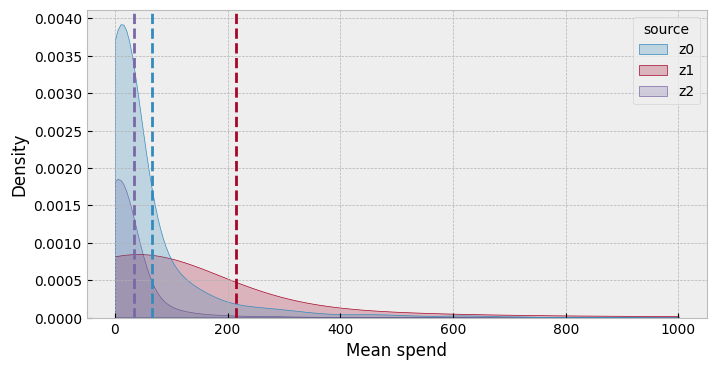

In [372]:
sns.kdeplot(data=tdf, x="z", hue="source", cut=0, clip=(0, 1000), fill=True)
plt.axvline(z_mean[0], color="C0", ls="--")
plt.axvline(z_mean[1], color="C1", ls="--")
plt.axvline(z_mean[2], color="C2", ls="--")
plt.xlabel("Mean spend");

In [373]:
# Assuming customers have the same remaining life, their value
# is the expected transaction value minus expected cost of aquisition
tdf["cacq"] = tdf["source"].map({"z0": 0, "z1": z1_avg_cacq, "z2": z2_avg_cacq})
tdf["clv"] = tdf["z"] - tdf["cacq"]

In [374]:
tdf["clv"].min()

-95.37914264255916

In [375]:
mean_clv = tdf.groupby("source")["clv"].mean()
mean_clv

source
z0     66.098137
z1    118.696462
z2    -43.738783
Name: clv, dtype: float64

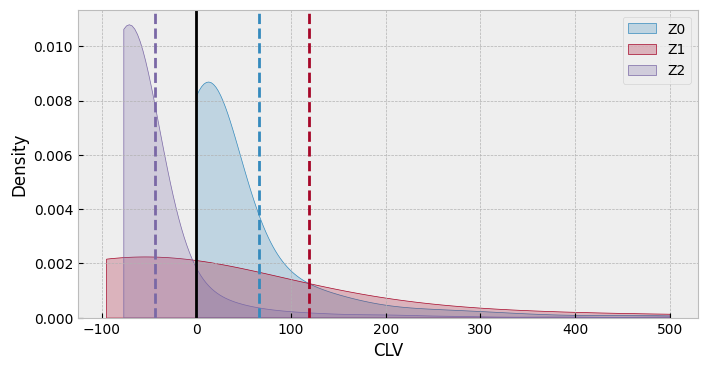

In [376]:
sns.kdeplot(data=tdf.query("source=='z0'"), x="clv", clip=(-100, 500), cut=0, fill=True, color="C0", label="Z0")
sns.kdeplot(data=tdf.query("source=='z1'"), x="clv", clip=(-100, 500),cut=0,  fill=True, color="C1", label="Z1")
sns.kdeplot(data=tdf.query("source=='z2'"), x="clv", clip=(-100, 500), cut=0, fill=True, color="C2", label="Z2")

plt.axvline(mean_clv[0], color="C0", ls="--")
plt.axvline(mean_clv[1], color="C1", ls="--")
plt.axvline(mean_clv[2], color="C2", ls="--")
plt.axvline(0, color="k")
# plt.axvspan(tdf["clv"].min(), 0, color="k", alpha=.1)
# plt.xlim([tdf["clv"].min(), None])
plt.xlabel("CLV")
plt.legend();

## Modelling

## Inference

## Decision making